# parm@frosst-y to SMIRNOFF

This notebook provides examples/utility functionality to assist with conversion of parm@frosst or relatives to SMIRNOFF format. Particularly, Christopher Bayly is generating modified AMBER `frcmod` files where the first entry for each parameter (i.e. `CT-CT-CT`) is replaced by the relevant SMIRKS pattern, for conversion into SMIRNOFF FFXML format. 

This notebook will:
1. Convert a specified smirks-frcmod file to SMIRNOFF FFXML
2. Generate (or take in) a set of molecules in OpenEye oemol format
3. Use the SMIRNOFF `ForceField` class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter.

Bayly has also updates the notebook with visualization for 3(b) and 3(c).

Bannan added printed current atom types to make looking up references easier

**Authors**:
* David L. Mobley (UCI)
* Contributions from Christopher I. Bayly (OpenEye Scientific Software Inc.) and Caitlin C. Bannan (UCI)


In [2]:
# Imports
from __future__ import print_function
from convert_frcmod import *
import openeye.oechem as oechem
import openeye.oeiupac as oeiupac
import openeye.oeomega as oeomega
import openeye.oedepict as oedepict
from IPython.display import display
from openforcefield.typing.engines.smirnoff.forcefield import *
from openforcefield.typing.engines.smirnoff.forcefield_utils import get_molecule_parameterIDs
from openforcefield.utils import *
% matplotlib inline
import matplotlib
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import time
import IPython
import pickle
import glob

# Relevant methods

# Relevant methods

In [3]:
def depictAtomByIdx(mol_copy, atomIdxList, supH = True, width=900, height=500):
    mol = oechem.OEMol(mol_copy)
    OEGenerate2DCoordinates(mol)
    atomBondSet = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in atomIdxList:
            atomBondSet.AddAtom( atom)
            for bond in atom.GetBonds():
                nbrAtom = bond.GetNbr(atom)
                nbrIdx = nbrAtom.GetIdx()
                if (nbrIdx in atomIdxList) and nbrIdx>atom.GetIdx():
                    atomBondSet.AddBond( bond)
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    aroStyle = oedepict.OEHighlightStyle_Color
    aroColor = oechem.OEColor(oechem.OEGrey)
    oedepict.OEAddHighlighting(disp, aroColor, aroStyle, 
                               oechem.OEIsAromaticAtom(), oechem.OEIsAromaticBond() )
    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightGreen)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)
    #ofs = oechem.oeosstream()
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img, disp)
    #oedepict.OERenderMolecule(ofs, 'png', disp)
    #ofs.flush()
    #return Image(data = "".join(ofs.str()))
    return Image(oedepict.OEWriteImageToString("png",img))

In [4]:
def getMolParamIDToAtomIndex( oemol, ff):
    """Take an OEMol and a SMIRNOFF forcefield object and return a dictionary,
    keyed by parameter ID, where each entry is a tuple of
    ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
    corresponding to that parameter ID and a list of the atom groups in that
    molecule that parameter is applied to.

    Parameters
    ----------
    oemol : OEMol
        OpenEye OEMol with the molecule to investigate.
    ff : ForceField
        SMIRNOFF ForceField object (obtained from an ffxml via ForceField(ffxml)) containing FF of interest.

    Returns
    -------
    param_usage : dictionary
        Dictionary, keyed by parameter ID, where each entry is a tuple of
        ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
        corresponding to that parameter ID and a list of the atom groups in
        that molecule that parameter is applied to.

    """
    labels = ff.labelMolecules([oemol])
    param_usage = {}
    for mol_entry in range(len(labels)):
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, smirks) in labels[mol_entry][force]:
                if not pid in param_usage:
                    param_usage[pid] = (smirks, [atom_indices])
                else:
                    param_usage[pid][1].append( atom_indices )

    return param_usage

In [5]:
def GetAtomInfo(mol, indices, skip_atoms = []):
    #print(indices)
    atoms_by_index = dict()
    charges_by_index = dict()
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        if idx in indices:
            atoms_by_index[idx] = atom
            charge = atom.GetFormalCharge()
            if charge == 0:
                charges_by_index[idx] = ''
            elif charge > -1:
                charges_by_index[idx] = '+%i' % charge
            else:
                charges_by_index[idx] = str(charge)
    atoms = [(atoms_by_index[idx],charges_by_index[idx]) for idx in indices]
    types = [atom.GetType() for (atom,charge) in atoms]
    atom_smarts = ['[#%i%s]' % (atom.GetAtomicNum(),charge) for (atom,charge) in atoms]
    smarts = '~'.join(atom_smarts)
    types = '~'.join(types)
    
    for (atom, charge) in atoms:
        if atom.GetAtomicNum() in skip_atoms:
            return (True, smarts, types)
    

    return (False, smarts, types)
    
def DepictMolWithParam(mol, indice_list, supH = False, print_atoms = True, skip_atoms = []):
    skip_count = 0
    for IdxByOccurrence in indice_list:
        
        skip_it, approx_smarts, types = GetAtomInfo(mol, IdxByOccurrence, skip_atoms)
        
        if skip_it:
            skip_count += 1
            continue
            
        if print_atoms:
            print("Approximate SMARTS: %s" % approx_smarts)
            print("Current Atom Types: %s" % types)
        display(depictAtomByIdx(mol, IdxByOccurrence, supH = supH))
    if skip_count > 0:
        skips = ','.join([str(i) for i in skip_atoms])
        print("This molecule contains %i fragment(s) with at least one atom in (%s)" % (skip_count, skips))

In [6]:
def make_param_histogram(param_id_counts, param_ids, letter, title):
    # Graph occurrences of bond parameters
    parm_ids = [ pid for pid in param_ids if pid[0]==letter]
    parm_ids.sort()
    counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
    #print( parm_ids)
    #print( counts_parms)
    split = int(len(parm_ids)/2)
    
    indices = np.arange(len(parm_ids))
    fix, ax = plt.subplots(2,1,figsize=(16,5))
    ax[0].set_yscale('log', nonposy='clip')
    ax[1].set_yscale('log', nonposy='clip')
    
    rects2 = ax[0].bar(indices[0:split], counts_parms[0:split] )
    ax[0].set_ylabel('Count')
    ax[0].set_xticks( indices[0:split])
    ax[0].set_xticklabels( parm_ids[0:split], rotation=-60, ha='left')
    ax[0].set_xlim(indices[0], indices[split])
    plt.yscale('log',nonposy='clip')
    rects2 = ax[1].bar(indices[split:], counts_parms[split:])
    ax[1].set_ylabel('Count')
    ax[1].set_xticks( indices[split:])
    ax[1].set_xticklabels( parm_ids[split:], rotation=-60, ha='left')
    ax[1].set_xlim(indices[split], indices[-1]+1)
    
    ax[0].set_title(title)
    plt.show()

In [7]:
def check_valence(mol):
    """
    Checks for hypervalency
    Parameter
    ---------
    mol - OEMol()

    Return
    ------
    boolean - True (no inappropriate valency)
              False (an atom with atomic number < 10 has > 4 Valence)
    """
    for atom in mol.GetAtoms():
        atomNum = atom.GetAtomicNum()
        # find number of neighbors to this atom
        valence = atom.GetValence()
        if atomNum <= 10: # first row elements
            if valence > 4:
                print("Found a #%i atom with valence %i in molecule %s" % (atomNum, valence, oechem.OECreateIsoSmiString(mol)))
                return False
    return True

## 1. Convert specified SMIRKS `frcmod` file to SMIRNOFF FFXML

In [8]:
# Input and output info
#infile = 'example.frcmod' # smirnoffish frcmod file to convert
infile = 'smirnoffishFrcmod.parm99Frosst.txt' # smirnoffish frcmod file to convert
ffxmlFile = 'smirnoff99Frosst.ffxml'
template = 'template.ffxml' # Template FFXML file without parameters (but with remainder of contents)

In [9]:
# Convert
# Already converted
convert_frcmod_to_ffxml( infile, template, ffxmlFile)

In [10]:
# Load SMIRNOFF FFXML
ff = ForceField(ffxmlFile) # We will use this below to access details of parameters

## 2. Generate or take in a set of molecules in OpenEye OEMol format

Here we will take a set of molecules from openforcefield (or elsewhere), read in all molecules and then uncomment any filters you want. 

Here are some examples of molecule sets in openforcefield (at /openforcefield/data/molecules/):
* `AlkEthOH_test_filt1_ff.mol2` - 42 alkanes, ethers, and alcohols with parm@frosst atom types
* `DrugBank_atyped.oeb` -  DrugBank database with parm@frosst atom types (including "untypable" atoms)
* `zinc-subset-parm@frosst.mol2.gz` - ZINC parm@frosst subset from CCL
    

In [10]:
# Un-comment this section if you want to use a local directory with individual mol2 files 
#DBpath = "path/to/molecules/*.mol2"
#DBpath = "/Users/bannanc/gitHub/FreeSolv/mol2files_sybyl/*mol2"
#DB_files = glob.glob(DBpath)
#molecules = list()
#for f in DB_files:
#    molecules += read_molecules(f, verbose=False)

# These are atoms you don't want in your set, in this case metaloids or nobel gases
skip_atoms = [2, 5, 14,33, 34, 52, 54] 

# Molecules file in openforcefield/data/molecules/ 
# OR any relative/absolute path
mol_File = 'DrugBank_atyped.oeb'
#mol_File = "zinc-subset-parm@frosst.mol2.gz"
#mol_File = "/Users/bannanc/Google Drive/RESEARCH/OFF_draftAndTestSpace/eMolecules_missingParameters/output.mol2"
molecules = read_molecules(mol_File)
# For use later, generate isomeric SMILES for these so we can easily look up molecules by smiles
isosmiles_to_mol = dict()
repeat = 0
skipped = 0

for mol in molecules:
    c_mol = OEMol(mol)
    oechem.OEAddExplicitHydrogens(c_mol)
    # Get the smiles string for this molecule
    smi = oechem.OECreateIsoSmiString(c_mol)
    # uncomment to skip molecules with > n heavy atoms
    n=200
    if OECount(c_mol, OEIsHeavy()) > n:
        continue
    
    # uncomment to skip molecules with metals
    #if OECount(c_mol, OEIsMetal()) > 0:
        #skipped +=1
    #    continue
    
    # uncomment to skip molecules containing the skip_atoms
    has_skip_atom = False
    for n in skip_atoms:
        if OECount(c_mol, OEHasAtomicNum(n)) > 0:
            has_skip_atom = True
    #if has_skip_atom:
        #skipped += 1
    #    continue
    
    # uncomment to skip molecules with 5 bonds to atoms with atomic number < 10 (i.e. pentavalent nitrogen)
    #if not check_valence(c_mol):
        #skipped += 1
    #    continue
    
    
    # uncomment to skip single molecules that contain > 1 molecule
    #if '.' in smi:
    #    skipped +=1 
    #    continue
        
    if smi in isosmiles_to_mol:
        repeat += 1
    isosmiles_to_mol[smi] = c_mol

oemols = [mol for smi, mol in isosmiles_to_mol.items()]
print("\nAfter filtering %i molecules there were %i repeated SMILES.\nThe final set has %i/%i molecules"\
      % (skipped, repeat, len(oemols), len(molecules)))

Loading molecules from '/Users/bannanc/Google Drive/RESEARCH/OFF_draftAndTestSpace/eMolecules_missingParameters/output.mol2'...
18 molecules read
0.005 s elapsed

After filtering 0 molecules there were 0 repeated SMILES.
The final set has 18/18 molecules


## 3. Determine parameter usage in molecules

Here we will use the SMIRNOFF ForceField class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter. We begin by just loading the SMIRNOFF forcefield we generated in section 1.

### 3(a). Determine which parameters are used in which molecules

Here we determine which parameters are actually used in which molecules, and make a couple example plots of the frequency of parameter occurrences for some of our example parameters.

In [11]:
# Track time
init_time = time.time()
# label molecules
labels = ff.labelMolecules(oemols, verbose = False)
elapsed = (time.time() - init_time) / 60.0
print("Assigned labels took %.2f minutes" % (elapsed))

Assigned labels took 0.03 minutes


In [12]:
# organize dictionaries to reference information 
init_time = time.time()
parameters_by_molecule = dict()
parameters_by_ID = dict()
param_ids = set()
param_id_counts = dict()
for idx, mol_dict in enumerate(labels):
    smi = OECreateIsoSmiString(oemols[idx])
    parameters_by_molecule[smi] = dict()
    for force_type, label_set in mol_dict.items():
        for (indices, pid, smirks) in label_set:
            if not pid in parameters_by_molecule[smi]:
                parameters_by_molecule[smi][pid] = list()
            parameters_by_molecule[smi][pid].append(indices)
            
            if not pid in parameters_by_ID:
                parameters_by_ID[pid] = set()
            parameters_by_ID[pid].add(smi)
            
            param_ids.add(pid)

for pid in param_ids:
    param_id_counts[pid] = 0
    
for smi, pid_dict in parameters_by_molecule.items():
    for pid, ind_list in pid_dict.items():
        param_id_counts[pid] += len(ind_list)   

elapsed = (time.time() - init_time) / 60.0
print("Organizing dictionaries took %.2f minutes" % (elapsed))

Organizing dictionaries took 0.00 minutes


For fun/info, do a quick graph of frequency of occurrence of particular parameters. Here, let's just do bond parameters

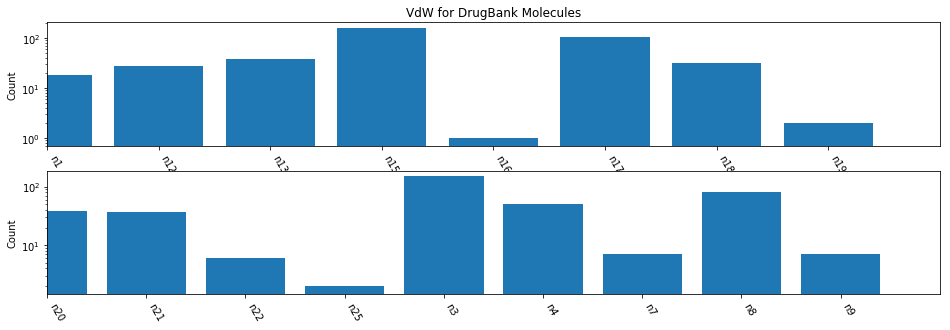

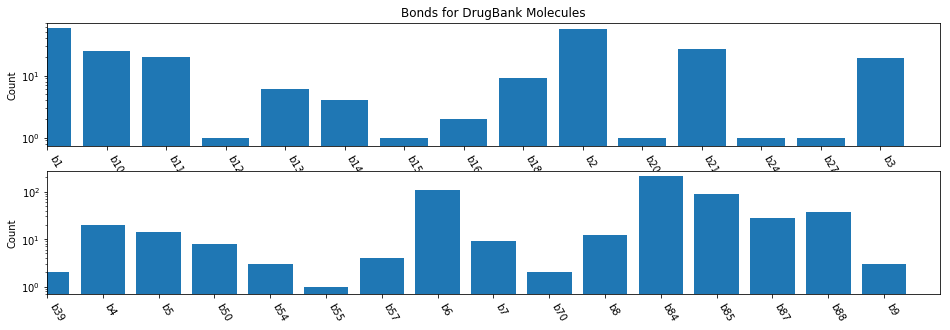

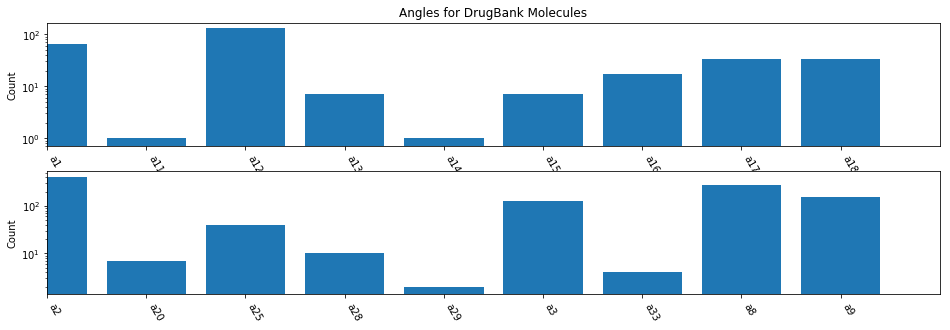

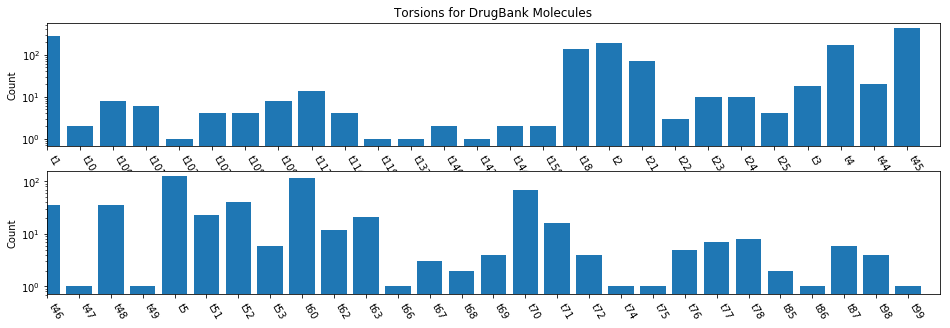

In [13]:
# Create Hisogram for each type of parameter
# VdW
make_param_histogram(param_id_counts, param_ids, 'n', "VdW for DrugBank Molecules")
# Bonds
make_param_histogram(param_id_counts, param_ids, 'b', "Bonds for DrugBank Molecules")
# Angles
make_param_histogram(param_id_counts, param_ids, 'a', "Angles for DrugBank Molecules")
# Torsions
make_param_histogram(param_id_counts, param_ids, 't', "Torsions for DrugBank Molecules")
#make_param_histogram(param_id_counts, param_ids, 'i', "Impropers for DrugBank Molecules")

### 3(b)-3(c). Determine which molecules do/do not contain selected parameter

Determine which molecules do and do not contain a specified parameter; give access to isomeric smiles and OEMol for each molecule in each case.

In [16]:
# INPUT: Pick what parameter to look at
parameter_id = 'n1' 

# For info, get details of that parameter
params = ff.getParameter(paramID=parameter_id)
print("For parameter %s, the relevant parameters are:" % parameter_id)
print(params)

# Find molecules which do/do not use that parameter
mols_with_param = []
mols_wo_param = []
for isosmi in parameters_by_molecule:
    # Store a tuple of (isomeric smiles, oemol) for each
    if parameter_id in parameters_by_molecule[isosmi].keys():
        mols_with_param.append( (isosmi, isosmiles_to_mol[isosmi] ))
    else:
        mols_wo_param.append( (isosmi, isosmiles_to_mol[isosmi] ))

print("\nThere are %s molecules containing that parameter and %s which do not, out of %s.\n" % 
      (len(mols_with_param), len(mols_wo_param), len(isosmiles_to_mol)))

# Print first 10 molecules not containing parameter
not_containing = min(10, len(mols_wo_param))
if not_containing == 0:
    print("\nAll molecules conatin parameter '%s'" % parameter_id)
elif not_containing <= 10:
    print("\nThe %i molecule(s) that do(es) not contain parameter '%s'" % (not_containing, parameter_id))
else:
    print("First 10 molecules not containing '%s' parameter:" % parameter_id)
for i in range(not_containing):
    print("   %s" % mols_wo_param[i][0])

# Print first 10 molecules containing parameter
containing = min(10,len(mols_with_param))
if containing == 0:
    print("\nNO molecules contain '%s' parameter" % parameter_id)
elif containing <= 10:
    print("\nThe %i molecule(s) containing '%s' parameter:" % (containing, parameter_id))
else:
    print("\nFirst 10 molecules containing '%s' parameter:" % parameter_id)

for i in range(containing):
    print("   %s" % mols_with_param[i][0])

For parameter n1, the relevant parameters are:
{'smirks': '[*:1]', 'epsilon': '0.25', 'id': 'n1', 'rmin_half': '4.'}

There are 18 molecules containing that parameter and 0 which do not, out of 18.


All molecules conatin parameter 'n1'

The 10 molecule(s) containing 'n1' parameter:
   B(C(CC(C)C)NC(=O)C(Cc1ccccc1)NC(=O)c2cnccn2)(O)O
   CC[Si](C)(C)C
   C[Si](C)(C)C(CC(=O)O)C(=O)O
   CCC1(c2cc-3n(c(=O)c2COC1=O)Cc4c3nc5ccccc5c4CC[Si](C)(C)C)O
   B(C(Cc1ccccc1)N)(O)O
   B(C(Cc1cccc(c1O)C(=O)O)NC(=O)C)(O)O
   B(C(Cc1cccc(c1)C(=O)O)NC(=O)Cc2ccccc2)(O)O
   B(C1CCCN1C(=O)C2CCCN2)(O)O
   B(c1ccc(c(c1)NS(=O)(=O)c2cc(cs2)S(=O)(=O)c3ccccc3)C(=O)O)(O)O
   B(CNC(=O)C(=NOC)c1csc(n1)N)(O)O


In [1]:
lowerlimit = 0
upperlimit = 100

# Skip showing molecule if the highlighted parameter 
# includes an element we know we don't have parameters for
skip_atoms = [2, 5, 14,33, 34, 52] 

# Correct with list of molecules is less than upper limit
if len(mols_with_param) < upperlimit:
    upperlimit = len(mols_with_param)

print("\nDepicting molecules %i to %i with parameter '%s'\n\n" % (lowerlimit,upperlimit-1, parameter_id))    

# Show molecules form lower to upper limit highlighting fragment with the parameter_id
for idx in range(lowerlimit, upperlimit):
    smiles = mols_with_param[idx][0]
    mol = mols_with_param[idx][1]
    skip_it = False
    OEAddExplicitHydrogens(mol)
    indice_list = parameters_by_molecule[smiles][parameter_id]
    print("looking at molecule %i" % idx)
    print('Selected smiles is %s' % smiles)
    print('Selected IUPAC name guessed: %s' % oeiupac.OECreateIUPACName(mol) )
    print( 'mol title and NumAtoms: ', mol.GetTitle(), mol.NumAtoms() )
    print( "Number of times '%s' appears:   %i" % (parameter_id, len(indice_list))) 
    DepictMolWithParam( mol, indice_list, supH = False, skip_atoms=skip_atoms)
    print()
    print()
    print()
    

NameError: name 'mols_with_param' is not defined